In [ ]:
import zipfile
import json
import pandas as pd
from tqdm import tqdm

NLP (Natural Language Processing, обработка естественного языка) — это направление в машинном обучении, посвященное распознаванию, генерации и обработке устной и письменной человеческой речи. Находится на стыке дисциплин искусственного интеллекта и лингвистики.

In [ ]:
df=pd.DataFrame(columns=['text','category','id_category'])
with zipfile.ZipFile('/content/drive/MyDrive/Machine Learning (ITHUB) /ДИ 2023/lessons/data/Копия zayavki.zip') as z:
  for filename in tqdm(z.namelist()):
    with z.open(filename) as f:
      text=f.read()
      s=text.decode('utf-8')
      js=json.loads(s)
      for feed in js['feed']:
        try:
          title=feed['meta']['title']
          if title=='Сообщение пользователя':
            msg=''
            for t in feed['payload']['body']:
              msg+=t['text']+' '
        except:
          continue
      ctg=js['reason']['category']['name']
      id_ctg=js['reason']['category']['id']
      df.loc[len(df)]=[msg.replace('X',''),ctg,id_ctg]

100%|██████████| 59889/59889 [04:32<00:00, 220.10it/s]


In [ ]:
js['reason']

{'id': 9,
 'name': 'Повреждения дорожного покрытия  проезжей части',
 'category': {'id': 3,
  'name': 'Благоустройство',
  'city_object': {'id': 3,
   'name': 'Улица',
   'icon': '/media/classifier/icons/objects-street.svg'}},
 'comment': '<p style="text-align:justify">Если вы обнаружили повреждения на дорожном покрытии проезжей части, не являющийся внутриквартальным, внутридворовым проездам или территорией, которые по вашему мнению влияют на безопасность дорожного движения, сохранение жизни, здоровья или имущества, &ndash; сообщите об этом, приложив панорамную фотографию, сделанную с доступного ракурса, на которой должно быть видно повреждение и можно было определить его четкое местонахождение. Фотография низкого качества, в том числе сделанная в движении, к рассмотрению не принимается. Фотоматериалы из сторонних Интернет-ресурсов не принимаются.</p>'}

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 59889 entries, 0 to 59888
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   text         59889 non-null  object
 1   category     59889 non-null  object
 2   id_category  59889 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 1.8+ MB


In [ ]:
df.head()

,text,category,id_category
0,"1й подъезд, 5 этаж. В коридоре над висит ка...",Содержание МКД,10
1,Маленькмй лифт изрисован внутри.,Содержание МКД,10
2,реклама на светофоре,Благоустройство,3
3,"1й подъезд, 5 этаж, квартирный холл. Рааботник...",Содержание МКД,10
4,незаконная решетка на фасаде,Нарушение правил пользования общим имуществом,23


## Предобработка данных

In [ ]:
!pip install pymorphy2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.5/55.5 kB 1.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.2/8.2 MB 65.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for docopt: filename=docopt-0.6.2-py2.py3-none-any.whl size=13705 sha256=64c6a417201572c6686c75f6f47e218cf88647f267a9fcb1e1a5e11283341329
  Stored in directory: /root/.cache/pip/wheels/fc/ab/d4/5da2067ac95b36618c629a5f93f809425700506f72c9732fac
Successfully built docopt


PyMorphy2 – морфологический анализатор русских текстов, который работает с морфологическим словарем OpenCorpora (http://opencorpora.org/), создаваемым на основе базы данных «Грамматического словаря русского языка»

Он умеет:

* приводить слово к нормальной форме (например, “люди -> человек”, или “гулял -> гулять”).
* ставить слово в нужную форму. Например, ставить слово во множественное число, менять падеж слова и т.д.
* возвращать грамматическую информацию о слове (число, род, падеж, часть речи и т.д.)

In [ ]:
import numpy as np
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import pymorphy2
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
import matplotlib.pyplot as plt
from wordcloud import WordCloud
nltk.download('wordnet')
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

Cтемминг (от англ. stemming) — это поиск основы слова, учитывающий морфологию исходного слова. Стемминг выполняет морфологический разбор слова, находит общую для всех его грамматических форм основу, отсекая суффиксы и окончания.

Лемматизация (англ. lemmatization) - это метод морфологического анализа, который сводится к приведению словоформы к ее первоначальной словарной форме (лемме).

In [ ]:
text=df['text'] #берем столбец с текстом
norm_text=[]
# 1 - только буквы
# 2 - перевод в нижний регистр
# 3 - привести все слова в единую форму
morph=pymorphy2.MorphAnalyzer()
for s in tqdm(text):
    s1 = re.sub(r'[^\w\s]+|[\d]+', r'',s).strip()
    s1 = s1.lower()
    s1 = word_tokenize(s1) #токенизация
    words=[]
    for i in s1:
        pv = morph.parse(i)
        words.append(pv[0].normal_form)
    sentence=' '.join(words)
    norm_text.append(sentence)

100%|██████████| 59889/59889 [03:50<00:00, 260.31it/s]


In [ ]:
#результат

In [ ]:
text[1]

'Маленькмй лифт изрисован внутри. '

In [ ]:
norm_text[1]

'маленькмть лифт изрисовать внутри'

## WordCloud

In [ ]:
df['norm_text']=norm_text

In [ ]:
cat23 = df[df['id_category']==23]['norm_text'].values
cat23 = ' '.join(cat23)
cat23

'незаконный решётка на фасад самовольно установить решётка на окно на лицевой фасад просить демонтировать самовольно установить решётка на окно на лицевой фасад просить демонтировать самовольно установить решётка на окно на лицевой фасад просить демонтировать самовольно установить рольставень на окно на лицевой фасад просить демонтировать решётка на лицевой фасад просить демонтировать решётка на лицевой фасад просить демонтировать решётка на лицевой фасад просить демонтировать решётка на фасад по набфонтанка просить демонтировать добрый день просьба разобраться ресторан установить кондиционер над парадный и образоваться конденсат который сделать вывод вода прям к парадный тем самый стекать всё при вход к парадный что способствовать образование наледь в зимний время год всё жилец хотеть устранить этот проблема первый двор от невский проспект незаконный решётка на фасад незаконный решётка на фамад незаконный кондиционер на фасад не согласовать вывешивание кондиционерный блок на фасад на 

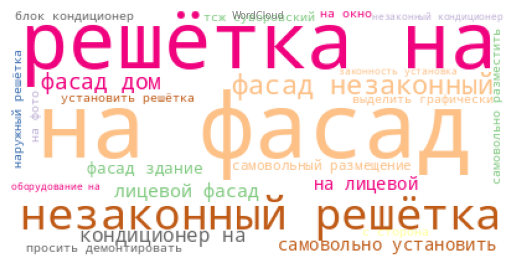

In [ ]:
fig = plt.figure()
fig.patch.set_facecolor('white')
plt.subplots_adjust(wspace=0.3, hspace=0.2)

wordcloud = WordCloud(colormap='Accent', background_color='white', contour_width=10).generate(cat23)
plt.tick_params(labelsize=10)
plt.imshow(wordcloud)
plt.axis("off")
plt.title('WordCloud',fontdict={'fontsize':7,'color':'grey'},y=0.93)
plt.tick_params(labelsize=10)

## Векторизация

Строчки в поле, подлежащем разметке, будем называть «документами». Совокупность всех документов — «корпус». Документы будут разбиты на слова (токены). Идущие подряд слова называются n-граммы. Слова и n-граммы вместе будем называть «терминами». Все термины составят «словарь».

Пример работы Count Vectorizer

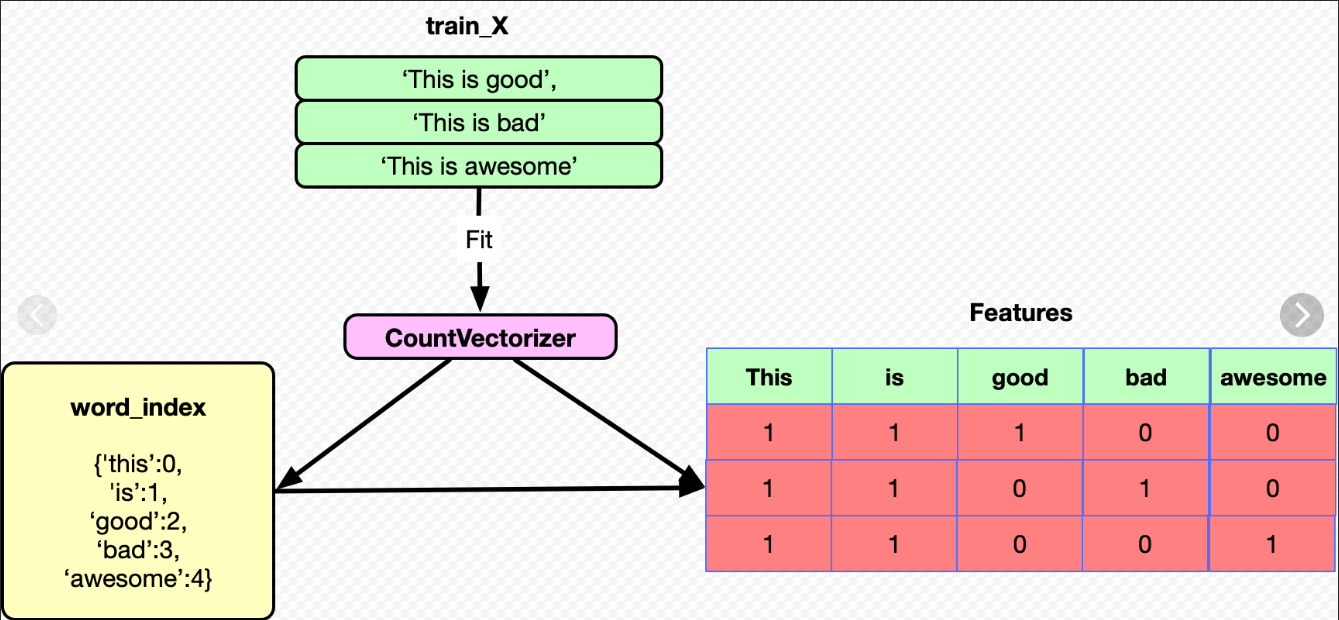

In [ ]:
russian_stopwords = stopwords.words("russian") #стоп-слова
vectorizer = CountVectorizer(max_features=500, min_df=20, max_df=0.7, stop_words=russian_stopwords)
text_cv = vectorizer.fit_transform(norm_text)
text_cv = pd.DataFrame(text_cv.toarray(),columns=vectorizer.get_feature_names_out())

In [ ]:
text_cv.head()

,httpgorodgovspbruproblems,аварийный,автомобиль,административный,администрация,адрес,арка,асфальт,асфальтовый,бак,...,щит,щиток,элемент,этаж,это,являться,ям,яма,январь,ящик
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,1,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Term Frequency-Inverse Document Frequency (TF-IDF) — это один из наиболее распространенных и мощных методов для извлечения признаков из текстовых данных. TF-IDF вычисляет важность каждого слова в документе относительно количества его употреблений в данном документе и во всей коллекции текстов. Этот метод позволяет выделить ключевые слова и понять, какие слова имеют больший вес для определенного документа в контексте всей коллекции.

Пример работы TF-IDF Vectorizer

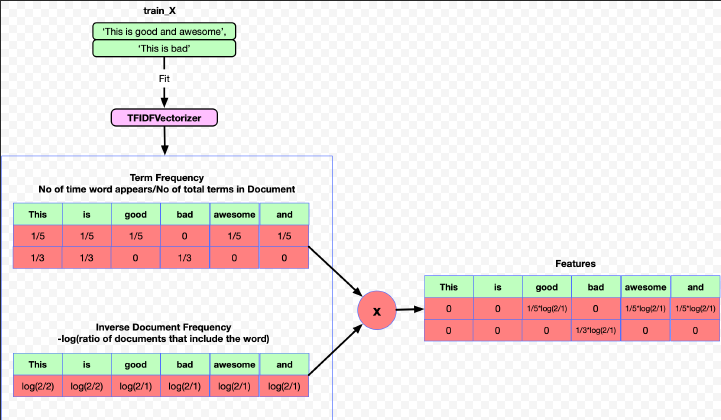

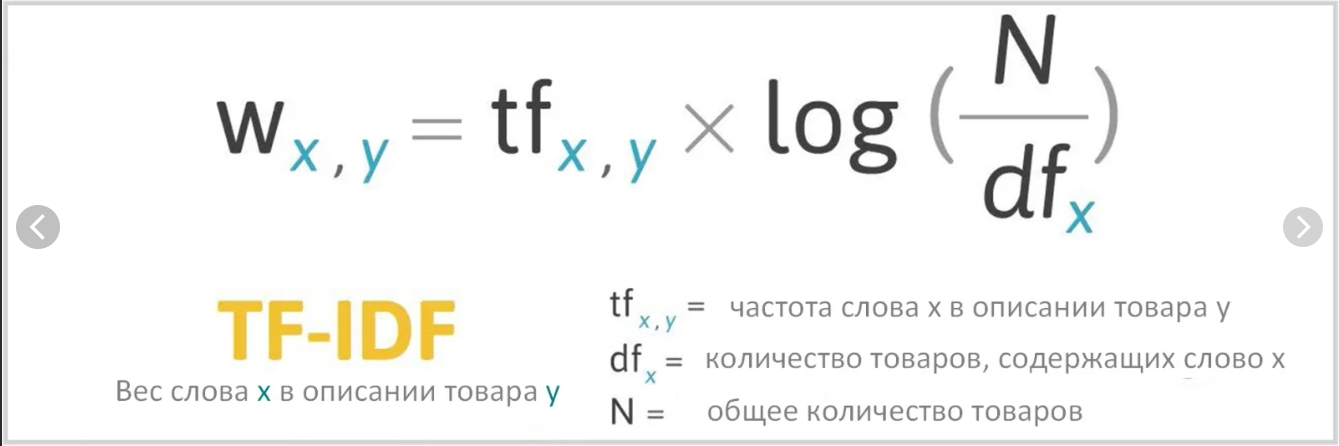

In [ ]:
vectorizer_tfidf = TfidfVectorizer(max_features=500, min_df=20, max_df=0.7, stop_words=russian_stopwords)
text_tfidf = vectorizer_tfidf.fit_transform(norm_text)
text_tfidf = pd.DataFrame(text_tfidf.toarray(),columns=vectorizer_tfidf.get_feature_names_out())
text_tfidf.head()

,httpgorodgovspbruproblems,аварийный,автомобиль,административный,администрация,адрес,арка,асфальт,асфальтовый,бак,...,щит,щиток,элемент,этаж,это,являться,ям,яма,январь,ящик
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.202361,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.138368,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
text[0]

'1й подъезд, 5 этаж. В коридоре над    висит какой-то провод. Возможно, под напряжением.\nПредседатель тсж "Ленинградские Вечера" отказывается принимать заявку на устранение более полугода.                                    '

In [ ]:
text[3]

'1й подъезд, 5 этаж, квартирный холл. Рааботники тсж "Ленинградские Вечера" вкрутили в стену крюк с цепью для хранения личных вещей.\nНеобходимо убрать цепь, демонтировать крюк и восстановить штукатурный слой стены.\nПредседатель тсж "Ленинградские Вечера" отказывается принимать заявку на устранение более полугода.               '

In [ ]:
text_cv['id_category']=df['id_category']
text_cv['category']=df['category']
text_cv.head()

,httpgorodgovspbruproblems,аварийный,автомобиль,административный,администрация,адрес,арка,асфальт,асфальтовый,бак,...,элемент,этаж,это,являться,ям,яма,январь,ящик,id_category,category
0,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,10,Содержание МКД
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,10,Содержание МКД
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,3,Благоустройство
3,0,0,0,0,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,10,Содержание МКД
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,23,Нарушение правил пользования общим имуществом
